In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

# from importlib import reload
# import feature_extraction
# reload(feature_extraction)
from plotting import (
    plot_series,
    plot_eeg_topomap_one_block,
    plot_eeg_topomap_all_blocks,
    plot_k_chaneels_by_r_value,
    plot_eeg_pearson_correlation_table,
    get_eeg_pearson_correlation_series_all_blocks,
    plot_time_series_by_epoch,
    plot_scatter_by_marker,
)
from biomarkers import (
    EEG,
    EMG,
    BP,
    EOG,
    ECG,
    TREV,
    GSR,
    EGG,
)
from feature_extraction import (
    Feature,
    EEG_BANDS,
    FEATURE_TO_FUNC,
)
from data_utils import (
    load_data_from_dir,
    get_all_behaviors_labels,
    get_all_features_by_marker,
    extract_labels,
    extract_features_by_channel,
    concatenate_all_data,
)
from calculate_correlation import (
    STAT_FEATURES,
    get_all_behaviors_feature_to_pc_by_markers,
    get_all_trials_average_rp_values,
)

# Train machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    GroupKFold,
    GridSearchCV,
    cross_val_score,
    cross_validate,
)

In [2]:
ALL_DIRS = ["../2000_CleanData", "../2001_CleanData", "../1004_CleanData"]

dir_to_data = {}
for dir_name in ALL_DIRS:
    all_data = load_data_from_dir(dir_name)
    dir_to_data[dir_name] = all_data

Complete loading 10 markers
Loaded audio_hvla block
Complete loading 10 markers
Loaded breath_nvha block
Complete loading 10 markers
Loaded breath_hvha block
Complete loading 10 markers
Loaded audio_nvla block
Complete loading 10 markers
Loaded breath_hvla block
Complete loading 10 markers
Loaded audio_nvha block
Complete loading 10 markers
Loaded mind wandering block
Complete loading 10 markers
Loaded meditation block
Complete loading 10 markers
Loaded audio_hvha block
Complete loading 10 markers
Loaded breath_nvla block
Complete loading 10 markers
Loaded mind wandering block
Complete loading 10 markers
Loaded audio_hvla block
Complete loading 10 markers
Loaded breath_hvla block
Complete loading 10 markers
Loaded breath_nvla block
Complete loading 10 markers
Loaded audio_nvla block
Complete loading 10 markers
Loaded breath_nvha block
Complete loading 10 markers
Loaded audio_nvha block
Complete loading 10 markers
Loaded audio_hvha block
Complete loading 10 markers
Loaded meditation blo

In [19]:
from data_utils import (
    extract_features,
    extract_labels,
)

features = STAT_FEATURES

""" extract features from physiological signals
"""
feature_names = []
all_feature_array = []
for m in [EOG.__name__, EMG.__name__]:
    f_array, names = extract_features(m, dir_to_data, features)
    all_feature_array.append(f_array)
    feature_names.extend(names)

all_feature_array = np.concatenate(all_feature_array, axis=-1)
all_label_array = extract_labels(dir_to_data)

print(all_feature_array.shape, len(feature_names), all_label_array['valence'].shape)

All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
(390, 40) 40 (390,)


(390, 40) (390,)
0.03485396848586321


<AxesSubplot:title={'center':'arousal Feature Importance'}>

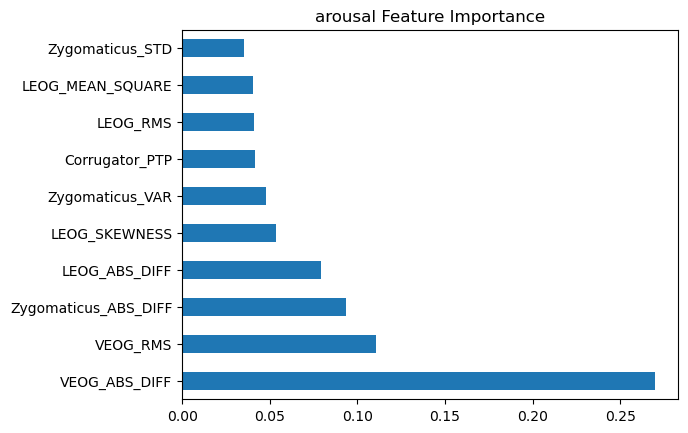

In [24]:
from sklearn.datasets import make_friedman1
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

bahavior = 'arousal'
X, y = all_feature_array, all_label_array[bahavior]
print(X.shape, y.shape)
X_train, X_test = X[:312], X[312:]
y_train, y_test = y[:312], y[312:]

est = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,loss='ls').fit(X_train, y_train)
print(mean_squared_error(y_test, est.predict(X_test)))

feat_importances = pd.Series(est.feature_importances_, index=feature_names)
feat_importances.nlargest(10).plot(
    kind="barh", title=f"{bahavior} Feature Importance"
)

In [3]:
def binary_label(all_labels, threshold=0.5):
    y_transformed = []
    c0, c1 = 0, 0
    for label in all_labels:
        if label < threshold:
            y_transformed.append(0)
            c0 += 1
        else:
            y_transformed.append(1)
            c1 += 1

    print(f"0 label: {c0}, 1 label: {c1}")
    return y_transformed


def get_tranformed_labels(condition_to_labels: dict):
    transformed = dict()
    for condition, label in condition_to_labels.items():
        transformed[condition] = binary_label(label)
    return transformed

def get_categorical_labels(condition_to_labels: dict, threshold=0.5, valence_threshold=0.75):
    valence_labels = condition_to_labels['valence']
    arousal_labels = condition_to_labels['arousal']
    claz = []
    for i, v_label in enumerate(valence_labels):
       if arousal_labels[i] <= threshold and v_label <= valence_threshold: # nvla
         claz.append(0)
       elif arousal_labels[i] > threshold and v_label <= valence_threshold: # nvha
         claz.append(1)
       elif arousal_labels[i] <= threshold and v_label > valence_threshold: # hvla
         claz.append(2)
       else: # hvha
         claz.append(3)            
        
    return claz

In [36]:
import tensorflow as tf
from tensorflow.keras import utils as np_utils
 
data_list = []
for m in [EEG.__name__, EGG.__name__]: # EOG.__name__, , EMG.__name__, EGG.__name__
    all_participants_data, condition_to_labels = concatenate_all_data(dir_to_data, m)
    all_epoch_data = np.swapaxes(
    all_participants_data, 0, -1
    )  # (num_channels, num_data_points, num_epochs) => (num_epochs, num_data_points, num_channels)

    data_list.append(all_epoch_data)

data_array = np.concatenate(data_list, axis=2)
 
# (TODO) combine attention + arousal to 2*2*2 = 8 classes

All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)


In [37]:
# to one-hot encoding vector
label_list = get_categorical_labels(condition_to_labels, valence_threshold=0.65)
groups_list = [[i] for i, j in enumerate(label_list)]
group_array = np.hstack(groups_list)
label_array = np_utils.to_categorical(label_list, num_classes=4) # nvla, nvha, hvla, hvha
#label_array = np.array(label_list['arousal'])

num_to_count = {0:0, 1: 0, 2: 0, 3:0}
for d in label_list:
    num_to_count[d] += 1
    
print(num_to_count)
print(data_array.shape, label_array.shape, group_array.shape)
num_channel = data_array.shape[2]

{0: 117, 1: 97, 2: 90, 3: 86}
(390, 12288, 129) (390, 4) (390,)


In [38]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

def cnn_model():
    clear_session()
    model = Sequential([
        Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(12288, num_channel)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPool1D(pool_size=2,strides=2),
        Conv1D(filters=5,kernel_size=3,strides=1),
        LeakyReLU(),
        MaxPool1D(pool_size=2,strides=2),
        Dropout(0.5),
        Conv1D(filters=5,kernel_size=3,strides=1),
        LeakyReLU(),
        AveragePooling1D(pool_size=2,strides=2),
        Dropout(0.5),
        Conv1D(filters=5,kernel_size=3,strides=1),
        LeakyReLU(),
        AveragePooling1D(pool_size=2,strides=2),
        Conv1D(filters=5,kernel_size=3,strides=1),
        LeakyReLU(),     
        GlobalAveragePooling1D(),
        Dense(4,activation='sigmoid')
    ])
    
    model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model=cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12286, 5)          1940      
                                                                 
 batch_normalization (BatchN  (None, 12286, 5)         20        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12286, 5)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6143, 5)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 6141, 5)           80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6141, 5)           0

In [39]:
accuracy=[]
gkf=GroupKFold()
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features, train_labels=data_array[train_index], label_array[train_index]
    val_features, val_labels=data_array[val_index], label_array[val_index]
    
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    model=cnn_model()
    model.fit(train_features, train_labels, epochs=13, batch_size=50,validation_data=(val_features,val_labels))
    accuracy.append(model.evaluate(val_features, val_labels)[1])

Epoch 1/13
7/7 [==============================] - 8s 552ms/step - loss: 1.3671 - accuracy: 0.3013 - val_loss: 1.3642 - val_accuracy: 0.3205
Epoch 2/13
7/7 [==============================] - 3s 417ms/step - loss: 1.3574 - accuracy: 0.3013 - val_loss: 1.3606 - val_accuracy: 0.2949
Epoch 3/13
7/7 [==============================] - 2s 303ms/step - loss: 1.3564 - accuracy: 0.3013 - val_loss: 1.3610 - val_accuracy: 0.3462
Epoch 4/13
7/7 [==============================] - 2s 294ms/step - loss: 1.3506 - accuracy: 0.3013 - val_loss: 1.3603 - val_accuracy: 0.3462
Epoch 5/13
7/7 [==============================] - 2s 295ms/step - loss: 1.3481 - accuracy: 0.3013 - val_loss: 1.3568 - val_accuracy: 0.3333
Epoch 6/13
7/7 [==============================] - 2s 296ms/step - loss: 1.3441 - accuracy: 0.3013 - val_loss: 1.3543 - val_accuracy: 0.3462
Epoch 7/13
7/7 [==============================] - 2s 301ms/step - loss: 1.3412 - accuracy: 0.3045 - val_loss: 1.3543 - val_accuracy: 0.3590
Epoch 8/13
7/7 [====

Epoch 5/13
7/7 [==============================] - 2s 288ms/step - loss: 1.3840 - accuracy: 0.2468 - val_loss: 1.3821 - val_accuracy: 0.3333
Epoch 6/13
7/7 [==============================] - 2s 286ms/step - loss: 1.3832 - accuracy: 0.2308 - val_loss: 1.3813 - val_accuracy: 0.3077
Epoch 7/13
7/7 [==============================] - 2s 289ms/step - loss: 1.3814 - accuracy: 0.2372 - val_loss: 1.3805 - val_accuracy: 0.2949
Epoch 8/13
7/7 [==============================] - 2s 288ms/step - loss: 1.3804 - accuracy: 0.2981 - val_loss: 1.3801 - val_accuracy: 0.2821
Epoch 9/13
7/7 [==============================] - 2s 297ms/step - loss: 1.3789 - accuracy: 0.3045 - val_loss: 1.3797 - val_accuracy: 0.2821
Epoch 10/13
7/7 [==============================] - 2s 305ms/step - loss: 1.3777 - accuracy: 0.3045 - val_loss: 1.3793 - val_accuracy: 0.2821
Epoch 11/13
7/7 [==============================] - 2s 298ms/step - loss: 1.3756 - accuracy: 0.3045 - val_loss: 1.3791 - val_accuracy: 0.2821
Epoch 12/13
7/7 [=

In [40]:
print(accuracy)
print(np.mean(accuracy))

[0.38461539149284363, 0.3205128312110901, 0.41025641560554504, 0.29487180709838867, 0.28205129504203796]
0.3384615480899811


In [ ]:
features = STAT_FEATURES
marker = ECG.__name__

""" extract features from physiological signals
"""
dir_name_to_features = extract_features_by_channel(marker, dir_to_data, features, 0)
dir_name_to_labels = extract_labels(dir_to_data)

In [ ]:
""" extract correlation from physiological signals
"""
num_channels = 4
num_blocks = 0
dir_name_to_ctf = {}
for dir_name, all_data in dir_to_data.items():
    dir_name_to_ctf[dir_name] = get_all_behaviors_feature_to_pc_by_markers(
        all_data, marker, features, num_channels, num_blocks
    )
    
avg_condition_to_features = get_all_trials_average_rp_values(
    dir_name_to_ctf, features, "pearson"
)
spearman_corr = get_all_trials_average_rp_values(dir_name_to_ctf, features, "spearman")
for b, feature_to_pc in avg_condition_to_features.items():
    for f, pc in feature_to_pc.items():
        avg_condition_to_features[b][f] = np.hstack((pc, spearman_corr[b][f]))

In [ ]:
all_data = dir_to_data["../2000_CleanData"]
channel_names = all_data["audio_hvla"].get_chanlocs(marker)

""" plot the time series given the marker and block
"""
# plot_time_series_by_epoch(all_data['audio_hvla'], 'EMG', 'audio_hvla', 0)


""" plot the single channel correlation table
"""
# channel = 3
# for condition, feature_to_pc in avg_condition_to_features.items():
#     label = f"{channel_names[channel]} {condition}"
#     plot_correlation_table_by_channel(
#         label, feature_to_pc, ["pearson r", "pearson p", "spearman r", "spearman p"], features, channel, True
#     )

""" plot the top channel correlation table given r values
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, True, 2)
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, False, 2)


""" plot the top channel correlation table with different blocks
"""
# all_block_names = list(all_data.keys())
# all_block_names.sort()
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_pearson_correlation_table(condition, feature_to_pc, all_block_names, 1)

""" plot the series for the top k channels
"""
# define number of rows and columns for subplots
# nrow = 3
# ncol = 2
# for condition, feature_to_pc in avg_condition_to_features.items():
#     print(f"{condition}")
#     ser_list = get_eeg_pearson_correlation_series_all_blocks(feature_to_pc, channel_names, k=20)
#     plot_series(nrow, ncol, ser_list)

""" plot the topography for eeg
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_topomap_all_blocks(condition, feature_to_pc)
#     for f in list(EEG_BANDS.keys()):
#         plot_eeg_topomap_one_block(condition, f, feature_to_pc, all_block_names)

In [ ]:
""" extract features from physiological signals
"""
dir_name_to_features = {}
dir_name_to_labels = {}
channel_num = 1
for dir_name, all_data in dir_to_data.items():
    feature_to_value = get_all_features_by_marker(
        all_data, marker, features, channel_num
    )

    dir_name_to_features[dir_name] = feature_to_value
    dir_name_to_labels[dir_name] = get_all_behaviors_labels(all_data)

features_to_trials = defaultdict()
for dir_name, fv in dir_name_to_features.items():
    for f, v in fv.items():
        if f not in features_to_trials:
            features_to_trials[f] = defaultdict()
        if dir_name not in features_to_trials[f]:
            features_to_trials[f][dir_name] = defaultdict()

        features_to_trials[f][dir_name] = v


In [ ]:
""" plot the scattor for physiological signals
"""
# plot_scatter_by_marker(marker, features_to_trials, dir_name_to_labels, channel_names[channel_num])

In [ ]:
# convert y values to categorical values
name_to_transformed = get_tranformed_labels(condition_to_labels)

label_name = "attention"
clf = LogisticRegression(max_iter=200)
gkf = GroupKFold(n_splits=5)
param_grid = {"classifier__C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
pipe = Pipeline([("scaler", StandardScaler()), ("classifier", clf)])
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=16)
gscv.fit(all_features,  name_to_transformed[label_name], groups=group_array)

best_model = gscv.best_estimator_
print(f"best model: {best_model}")
print(gscv.best_score_)

In [ ]:
# BP feature shape (13, 11)
# ECG feature shape (13, 11) 22
# EEG feature shape (13, 1408) 1430
# EGG feature shape (13, 11) 1441
# EMG feature shape (13, 22) 1463
# EOG feature shape (13, 22) 1485
# GSR feature shape (13, 11) 1496
# Resp feature shape (13, 11) 1507
# TREV feature shape (13, 11) 1518
# features = (mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
#                           mean_square(data),rms(data),abs_diffs_signal(data),
#                           skewness(data),kurtosis(data))
# EEG spetral features shape (13, 768) 2286-768=


def get_stats_name(i) -> str:
    pos = i % 11
    return STAT_FEATURES[pos]


def get_feature_names(features):
    index = []
    for i, j in enumerate(features):
        stat_name = get_stats_name(i)
        if i < 11:
            name = "BP"
        elif i < 22:
            name = "ECG"
        elif i < 1430:
            channel = int((i - 22) / 11) + 1
            name = f"EEG {channel}"
        elif i < 1441:
            name = "EGG"
        elif i < 1463:
            channel = int((i - 1441) / 11) + 1
            name = f"EMG {channel}"
        elif i < 1485:
            channel = int((i - 1463) / 11) + 1
            name = f"EOG {channel}"
        elif i < 1496:
            name = "GSR"
        elif i < 1507:
            name = "Resp"
        elif i < 1518:
            name = "TREV"
        else:
            channel = int((i - 1518) / 6) + 1
            name = f"EEG {channel}"
            stat_name = EEG_BANDS[(i - 1518) % 6]

        index.append(f"{name} {stat_name}")
    return index

In [ ]:
# assume bigger coefficents has more contribution to the model
# but have to be sure that the features has THE SAME SCALE otherwise this assumption is not correct.
importance = best_model["classifier"].coef_[0]

feat_importances = pd.Series(importance, index=get_feature_names(importance))
feat_importances.nlargest(10).plot(
    kind="barh", title=f"{label_name} Feature Importance"
)